# Setup and dependencies

In [1]:
from mobile_sam import SamAutomaticMaskGenerator
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from collections import deque

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_21m_224. This is bec

In [2]:
FILEPATH = "main-image.jpeg"
image = cv2.imread(FILEPATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# plt.imshow(image)

# Captioning with BLIP

In [13]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

prompt = "Question: What people or objects or events are present in the image? Answer:"
inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Generating bounding boxes with GroundingDINO

In [3]:
import sys
sys.path.insert(1, 'GroundingDINO')
from groundingdino.util.inference import load_model, load_image, predict, annotate
import os
import supervision as sv
from torchvision.ops import box_convert

model = load_model("./GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py", "./weights/groundingdino_swint_ogc.pth")

# TEXT_PROMPT = "person . saint . soldier . shield . halo . whip"
TEXT_PROMPT = "object . person"
BOX_THRESHOLD = 0.3
TEXT_THRESHOLD = 0.25

originalImage, DINOimage = load_image(FILEPATH)

boxes, logits, phrases = predict(
    model=model, 
    image=DINOimage, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_THRESHOLD, 
    text_threshold=TEXT_THRESHOLD,
    device="cpu"
)

final text_encoder_type: bert-base-uncased


SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


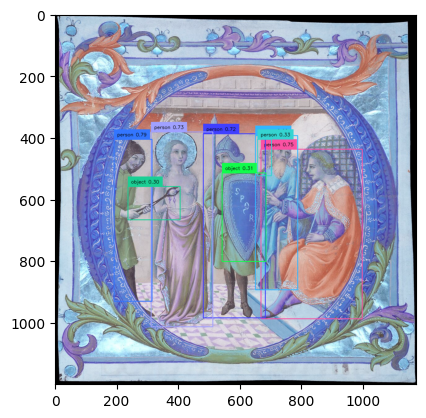

In [4]:
# Visualising image and annotations with bounding boxes
annotated_frame = annotate(image_source=originalImage, boxes=boxes, logits=logits, phrases=phrases)
plt.imshow(annotated_frame)

In [5]:
xywh = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xywh").numpy()
xyxy = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()

In [6]:
WIDTH = image.shape[0]
HEIGHT = image.shape[1]

xywh[:, 0] *= WIDTH
xywh[:, 1] *= HEIGHT
xywh[:, 2] *= WIDTH
xywh[:, 3] *= HEIGHT

xyxy[:, 0] *= WIDTH
xyxy[:, 1] *= HEIGHT
xyxy[:, 2] *= WIDTH
xyxy[:, 3] *= HEIGHT

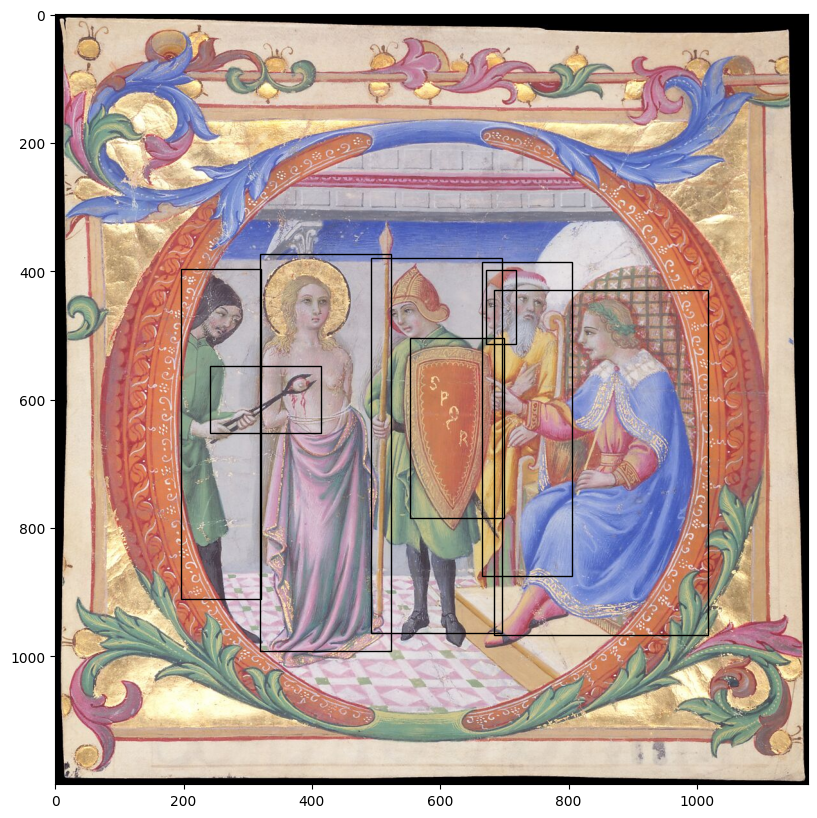

In [7]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for box in xywh:
    x, y, w, h = box
    rect = plt.Rectangle((x, y), w, h, edgecolor='black', facecolor='none', linewidth=1)
    plt.gca().add_patch(rect)
plt.show()

# Generating masks with MobileSAM

In [8]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

# Expects xyxy format
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='black', facecolor=(0,0,0,0), lw=2))  

In [9]:
from mobile_sam import sam_model_registry, SamPredictor

sam_checkpoint = "./weights/mobile_sam.pt"
model_type = "vit_t"

device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
sam.eval()

predictor = SamPredictor(sam)
predictor.set_image(image)

In [10]:
maskSet = np.empty((0, image.shape[0], image.shape[1]), dtype=bool)
for i in range(0, xyxy.shape[0]):
    input_box = np.array(xyxy[i])
    masks, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box[None, :],
        multimask_output=False,
    )
    maskSet = np.concatenate((maskSet, masks[0][None, :, :]), axis=0)

In [11]:
aggregatedMasks = np.any(maskSet, axis=0)

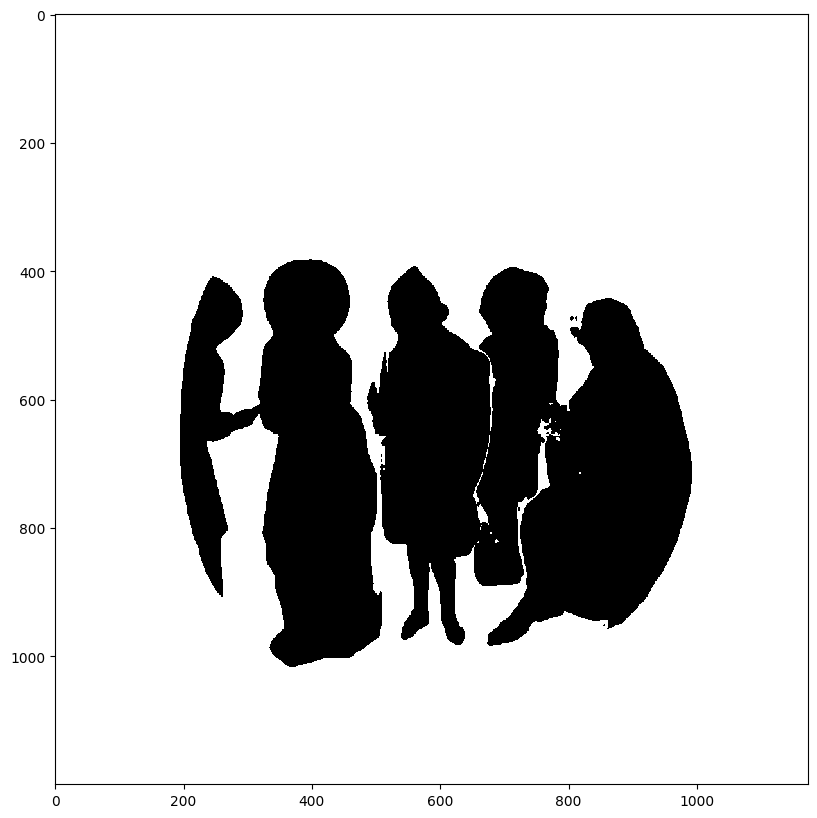

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
# plt.imshow(union_mask.astype(float), alpha=0.6, cmap='Blues', interpolation='none')
plt.imshow(aggregatedMasks.astype(float), cmap='Greys', interpolation='none')
plt.show()

(-0.5, 1172.5, 1199.5, -0.5)

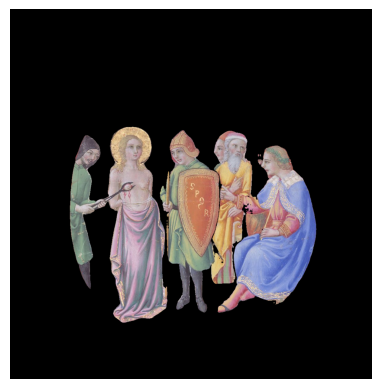

In [16]:
aggregatedMasks = aggregatedMasks.astype(bool)

# Apply the mask to each channel of the image
masked_image = np.zeros_like(image)
for i in range(3):  # Assuming the last dimension is the color channel
    masked_image[..., i] = image[..., i] * aggregatedMasks

# Display the masked image
plt.imshow(masked_image)
plt.axis('off') 

In [19]:
import imageio

imageio.imwrite('masked_image.jpg', masked_image)

In [17]:
distanceMask = aggregatedMasks.astype(float)

ROWS = distanceMask.shape[0]
COLUMNS = distanceMask.shape[1]
OUT_MASK_VALUE = 0
INITIAL_MASK_VALUE = 1
STEP_FACTOR = 1

# Queue has default mask positions
queue = deque()
for i in range(ROWS):
    for j in range(COLUMNS):
        if distanceMask[i, j] == INITIAL_MASK_VALUE:
            queue.append((i, j))

# BFS
cycle = 2
i = 2
while queue:
    next_queue = deque()
    while queue:
        i, j = queue.popleft()
        for rowOffset in [-1, 0, 1]:
            for columnOffset in [-1, 0, 1]:
                neighbor_i = i + rowOffset
                neighbor_j = j + columnOffset
                if 0 <= neighbor_i < ROWS and 0 <= neighbor_j < COLUMNS:
                    if distanceMask[neighbor_i, neighbor_j] == OUT_MASK_VALUE:
                        distanceMask[neighbor_i, neighbor_j] = cycle
                        next_queue.append((neighbor_i, neighbor_j))
    queue = next_queue
    i += 1
    if i % STEP_FACTOR == 0:
        cycle += 1

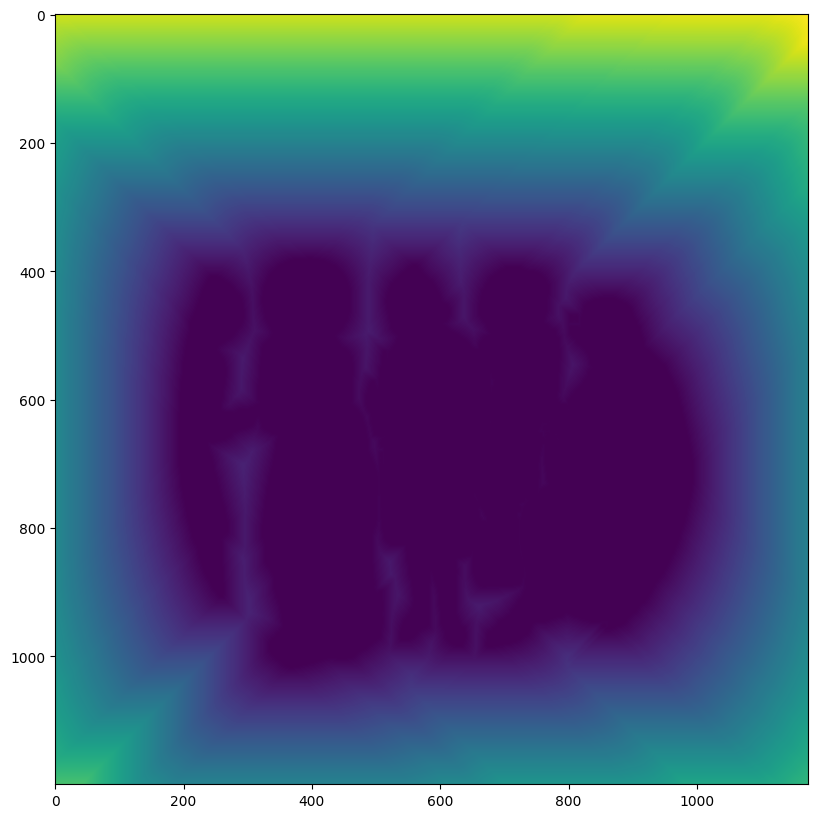

In [18]:
plt.figure(figsize=(10, 10))
plt.imshow(distanceMask)